# Applied Deep Learning for Scientists

### Tutorial 5: Step-by-step Pytorch Tutorial with Variational Autoencoders (VAEs)


At the end of this tutorial, you will:

- Be able to build a machine learning model from scratch and train it end-to-end
- Understand and implement variational Autoencoders (VAEs)

##Import dependencies (run the following cells)

In [1]:
# @title import dependencies

from typing import Mapping, Union, Optional
from pathlib import Path

import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms

import os
import pickle
from tqdm.notebook import tqdm

from __future__ import print_function, division


In [2]:
# @title reproducibility stuff

import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False

### [Auto-encoding Variational Bayes](https://arxiv.org/abs/1312.6114)
We start considering the inputs, hidden representations, and reconstructed outputs of a VAE as probabilistic random variables within a directed graphical model.

With a Bayesian perspective:
- The encoder becomes a variational inference network, mapping observed inputs to (approximate) posterior distributions for each latent attribute. That is, our encoder describes an entire probability distribution for each latent attribute and the latent code is *sampled* from this distributions.
- The decoder becomes a generative network, capable of mapping latent codes to new samples similar to the input ones.

So the training dataset becomes the tip of an iceberg; the observed result of an **underlying causative probabilistic process**.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/vae1.png)



# Variational Autoencoder




![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/implementation.png)



### Intuition: encoding probability distributions (from Jeremy Jordan's [blog post](https://www.jeremyjordan.me/variational-autoencoders/))



Let's suppose we've trained an autoencoder model on a large dataset of faces with a encoding dimension of 6. An ideal autoencoder will learn descriptive attributes of faces such as skin color, whether or not the person is wearing glasses, etc. in an attempt to describe an observation in some compressed representation.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/int1.png)

In the example above, we've described the input image in terms of its latent attributes using a **single value to describe each attribute**.

However, we may prefer to represent each latent attribute as a range of possible values. For instance, what *single value* would you assign for the smile attribute if you feed in a photo of the Mona Lisa? Using a variational autoencoder, we can describe latent attributes in probabilistic terms.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/int2.png)


With this approach, we'll now represent each latent attribute for a given input as a probability distribution. When decoding from the latent state, we'll randomly sample from each latent state distribution to generate a vector as input for our decoder model.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/int3.png)

By constructing our encoder model to output a range of possible values (a statistical distribution) from which we'll randomly sample to feed into our decoder model, we're essentially enforcing a continuous, smooth latent space representation. For any sampling of the latent distributions, we're expecting our decoder model to be able to accurately reconstruct the input. Thus, values which are nearby to one another in latent space should correspond with very similar reconstructions.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/int4.png)

### Implementation overview

Now that we are close to code, have you noticed the elephant in the room? VAEs require to sample from the distribution predicted by the encoder to obtain a latent code for the decoder, but how can we backpropagate gradients through a fundamentally random operation such as sampling?



#### Reparameterization trick

We need the reparameterization trick in order to backpropagate through a random node.


Given:



In [3]:
# Some data
data = torch.rand(10)

# Some parameters to train
deterministic_transform1 = torch.nn.Linear(in_features=10,  out_features=10)
deterministic_transform2 = torch.nn.Linear(in_features=10,  out_features=10)

# My expected output
gold_output = torch.ones(10)

We want optimize the parameters in order to obtain `gold_output` from the following computation:

In [4]:
# My stochastic prediction
pred_mean = deterministic_transform1(data)
pred_std = torch.ones_like(data)

sampling = torch.normal(mean=pred_mean, std=pred_std)     # random numbers drawn from **separate** normal distributions
                                                          # whose mean and standard deviation are given.

pred_output = deterministic_transform2(sampling)

# Error function
loss = F.mse_loss(pred_output, gold_output)
deterministic_transform1.zero_grad()
loss.backward()

# then optimize with some optimizer

But...

In [5]:
deterministic_transform1.weight.grad

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

We have a problem, this doesn’t work! We don’t have any gradients! They are zero even though you can be sure that the prediction is not perfect:


In [6]:
loss  #  ...since the loss is not zero

tensor(2.0999, grad_fn=<MseLossBackward0>)



The specific problem here is that we can’t backpropagate through the random `normal` function.

This makes sense right? We are trying to back propagate through a stochastic node in the computational graph.
It doesn’t make much sense to differentiate with respect to a stochastic node since that means the gradient would technically be a random variable too!

So let’s... reparametrize! That is, let’s change how the parameters are incorporated into the model.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/trick.png)


In [7]:
# My stochastic prediction
pred_mean = deterministic_transform1(data)
pred_std = torch.ones_like(data)

# Reparametrization trick:
rand_source = torch.randn(10)                       # random numbers drawn from **separate** canonical normal distributions
sampling = rand_source * pred_std + pred_mean       # Rescale each normal distribution to match our predictions

pred_output = deterministic_transform2(sampling)

# My error
loss = F.mse_loss(pred_output, gold_output)
deterministic_transform1.zero_grad()
loss.backward()

# then optimize with some optimizer

In [8]:
deterministic_transform1.weight.grad

tensor([[-0.0943, -0.0978, -0.0409, -0.1025, -0.0417, -0.0642, -0.0274, -0.0848,
         -0.1005, -0.0142],
        [ 0.0186,  0.0193,  0.0081,  0.0202,  0.0082,  0.0127,  0.0054,  0.0167,
          0.0198,  0.0028],
        [-0.0424, -0.0440, -0.0184, -0.0461, -0.0188, -0.0289, -0.0123, -0.0381,
         -0.0452, -0.0064],
        [ 0.1200,  0.1245,  0.0521,  0.1305,  0.0531,  0.0817,  0.0349,  0.1080,
          0.1280,  0.0181],
        [ 0.0805,  0.0835,  0.0349,  0.0876,  0.0356,  0.0548,  0.0234,  0.0724,
          0.0859,  0.0122],
        [ 0.0271,  0.0281,  0.0118,  0.0295,  0.0120,  0.0185,  0.0079,  0.0244,
          0.0289,  0.0041],
        [ 0.1264,  0.1311,  0.0549,  0.1375,  0.0559,  0.0861,  0.0368,  0.1137,
          0.1348,  0.0191],
        [ 0.0354,  0.0367,  0.0154,  0.0385,  0.0157,  0.0241,  0.0103,  0.0319,
          0.0378,  0.0053],
        [-0.2037, -0.2112, -0.0884, -0.2215, -0.0901, -0.1387, -0.0592, -0.1832,
         -0.2172, -0.0307],
        [ 0.1660,  

That's it, now we can adjust the parameters of the distribution to improve our stochastic prediction!

**We constructed the parameterized random variable via a parameterized deterministic function of a parameter-free random variable.**


## Implementing a VAE

Hyperparameters

In [9]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 2
num_epochs = 40
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")


### Data Loading

MNIST images show digits from `0-9` in `28x28` grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities $p \in [0,1]$

In [10]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=max(10000, batch_size), shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 77986384.26it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 56579025.61it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24043482.66it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3562178.15it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw




#### **Encoder and Decoder**
We'll use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

**Bottleneck**

In the convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.


**Deconvolution**

In the decoder we are using a transposed convolution, also known as deconvolution. You can think of it as the convolution in the opposite direction.  ([here](https://github.com/vdumoulin/conv_arithmetic) more visualizations)

*Blue cells are inputs, and cyan cells are outputs*

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/deconv.gif)



**Kernel size**

We are using `kernel_size=4`. The motivation behind this choice is to lessen the checkerboard artifacts described [here](https://distill.pub/2016/deconv-checkerboard)

In [12]:
class Encoder(nn.Module):
    def __init__(self, hidden_channels: int, latent_dim: int) -> None:
        """
        Simple encoder module

        It predicts the `mean` and `log(variance)` parameters.

        The choice to use the `log(variance)` is for stability reasons:
        https://stats.stackexchange.com/a/353222/284141
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=hidden_channels,
                               kernel_size=4,
                               stride=2,
                               padding=1) # out: hidden_channels x 14 x 14

        self.conv2 = nn.Conv2d(in_channels=hidden_channels,
                               out_channels=hidden_channels*2,
                               kernel_size=4,
                               stride=2,
                               padding=1) # out: (hidden_channels x 2) x 7 x 7

        self.fc_mu = nn.Linear(in_features=hidden_channels*2*7*7,
                               out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=hidden_channels*2*7*7,
                                   out_features=latent_dim)

        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> (torch.Tensor, torch.Tensor):
        """
        :param x: batch of images with shape [batch, channels, w, h]
        :returns: the predicted mean and log(variance)
        """
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))

        x = x.view(x.shape[0], -1)

        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)

        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, hidden_channels: int, latent_dim: int) -> None:
        """
        Simple decoder module
        """
        super().__init__()
        self.hidden_channels = hidden_channels

        self.fc = nn.Linear(in_features=latent_dim,
                            out_features=hidden_channels*2*7*7)

        self.conv2 = nn.ConvTranspose2d(in_channels=hidden_channels*2,
                                        out_channels=hidden_channels,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=hidden_channels,
                                        out_channels=1,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)

        self.activation = nn.ReLU()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        :param x: a sample from the distribution governed by the mean and log(var)
        :returns: a reconstructed image with size [batch, 1, w, h]
        """
        x = self.fc(x)
        x = x.view(x.size(0), self.hidden_channels*2, 7, 7)
        x = self.activation(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x


#### **VAE**

The VAE definition is straghforward since we have all the pieces we need:
- The Encoder
- The reparametrization trick we saw in the last section
- The Decoder




In [17]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, hidden_channels: int, latent_dim: int):
        super().__init__()
        self.encoder = Encoder(hidden_channels=hidden_channels,
                               latent_dim=latent_dim)
        self.decoder = Decoder(hidden_channels=hidden_channels,
                               latent_dim=latent_dim)

    def forward(self, x):
        # TODO
        # Hint: remember we want to sample from the posterior distribution; use latent_sample()
        # return x_recon, latent_mu, latent_logvar
        # pass
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):

        if self.training:
            # Convert the logvar to std
            std = (logvar * 0.5).exp()

            # pytorch built-in implementation for the reparameterization trick
            return torch.distributions.Normal(loc=mu, scale=std).rsample()

            # Or if you prefer to do it without a torch.distribution...
            # std = logvar.mul(0.5).exp_()
            # eps = torch.empty_like(std).normal_()
            # return eps.mul(std).add_(mu)
        else:
            return mu

vae = VariationalAutoencoder(hidden_channels=capacity, latent_dim=latent_dims)
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


#### Loss function



In [18]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # You can look at the derivation of the KL term here https://arxiv.org/pdf/1907.08956.pdf
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence

# More on this later on and in the theoretical lesson!

### Training VAE


In [19]:
# @title training utilities

import pandas as pd
import numpy as np

from typing import Callable, Optional
def make_averager() -> Callable[[Optional[float]], float]:
    """ Returns a function that maintains a running average

    :returns: running average function
    """
    count = 0
    total = 0

    def averager(new_value: Optional[float]) -> float:
        """ Running averager

        :param new_value: number to add to the running average,
                          if None returns the current average
        :returns: the current average
        """
        nonlocal count, total
        if new_value is None:
            return total / count if count else float("nan")
        count += 1
        total += new_value
        return total / count

    return averager

def save_in_dataframe(df_log, labels, mus, stddevs, epoch):
    df = pd.DataFrame()

    df['index'] = np.arange(len(mus[:,0])) * epoch
    df['image_ind'] = np.arange(len(mus[:,0]))
    df['class'] = labels.data.numpy().astype(str)
    df['mu_x'] = mus[:,0]
    df['mu_y'] = mus[:,1]
    df['std_x'] = stddevs[:,0]
    df['std_y'] = stddevs[:,1]
    df['epoch'] = np.ones(len(mus[:,0])) * epoch

    df_log = pd.concat([df_log, df])

    return df_log

def run_on_testbatch(df_log, vae, epoch, x, y):
    with torch.no_grad():
        x = x.to(device)
        x, mus, stddevs = vae(x)
        x = x.to('cpu')
        mus = mus.to('cpu').data.numpy()
        stddevs = stddevs.to('cpu').mul(0.5).exp_().data.numpy()

    return save_in_dataframe(df_log, y, mus, stddevs, epoch)

def plot_loss(losses):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=list(range(len(losses))),
        y=losses,
        # name="Name of Trace 1"       # this sets its legend entry
    ))

    fig.update_layout(
        title="Train loss",
        xaxis_title="Epoch",
        yaxis_title="Loss",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="#7f7f7f"
        )
    )
    return fig

def refresh_bar(bar, desc):
    bar.set_description(desc)
    bar.refresh()


In [20]:
# 🚥 10 minutes with default parameters 🚥

# --- in a few cells you can download some pre-trained weights ---

vae = VariationalAutoencoder(hidden_channels=capacity, latent_dim=latent_dims)
vae = vae.to(device)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

df_log = pd.DataFrame()
test_batch_x, test_batch_y = next(iter(test_dataloader))
df_log = run_on_testbatch(df_log, vae, 0, test_batch_x, test_batch_y )

train_loss_avg = []

print('Training ...')

tqdm_bar = tqdm(range(1, num_epochs+1), desc="epoch [loss: ...]")
for epoch in tqdm_bar:
    train_loss_averager = make_averager()

    batch_bar =  tqdm(train_dataloader, leave=False, desc='batch', total=len(train_dataloader))
    for image_batch, _ in batch_bar:

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # vae loss computation
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer
        optimizer.step()

        refresh_bar(batch_bar, f"train batch [loss: {train_loss_averager(loss.item()):.3f}]")

    refresh_bar(tqdm_bar, f"epoch [loss: {train_loss_averager(None):.3f}]")

    train_loss_avg.append(train_loss_averager(None))
    df_log = run_on_testbatch(df_log, vae, epoch, test_batch_x, test_batch_y )

df_log = df_log.set_index(['index'])
plot_loss(train_loss_avg)

Training ...


epoch [loss: ...]:   0%|          | 0/40 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

## Latent space (from Jeremy Jordan's [blog post](https://www.jeremyjordan.me/variational-autoencoders/))

Using VAEs we are able to learn **smooth latent state representations** of the input data. For standard autoencoders, we simply need to learn an encoding which allows us to reproduce the input.

As you can see in the left-most figure, focusing only on reconstruction loss does allow us to separate out the classes (in this case, MNIST digits) which should allow our decoder model the ability to reproduce the original handwritten digit, but there's an uneven distribution of data within the latent space. In other words, there are areas in latent space which don't represent any of our observed data.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/latent.png)



On the flip side, if we only focus only on ensuring that the latent distribution is similar to the prior distribution (through our KL divergence loss term), we end up describing every observation using the same unit Gaussian, which we subsequently sample from to describe the latent dimensions visualized. This effectively treats every observation as having the same characteristics; in other words, we've failed to describe the original data.

However, when the two terms are optimized simultaneously, we're encouraged to describe the latent state for an observation with distributions close to the prior but deviating when necessary to describe salient features of the input.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/distr.png)


In the following cells you can visualize how the training modified the latent space of our network.




In [21]:
# @title Trained VAE

import plotly.express as px

n_samples = 1010 #@param {type:"slider", min:10, max:5000, step:10}
size_exactly_as_std = False #@param {type:"boolean"}

def plot_latent_params(df, max_size: bool):
    if size_exactly_as_std:
        size_max = 200
    else:
        size_max=None

    return px.scatter(
        df.loc[df['image_ind'] < n_samples],
        x="mu_x", y="mu_y",
        animation_frame="epoch", animation_group="image_ind",
        size="std_x",
        color="class",
        hover_name="image_ind", #facet_col="class",
        color_discrete_sequence=px.colors.qualitative.Plotly,
        width=800,
        height=800,
        size_max=size_max,
        range_x=[-5, 5],
        range_y=[-5, 5])

plot_latent_params(df_log, max_size = size_exactly_as_std)

In [23]:
# @title Untrained VAE

import plotly.express as px

n_samples = 170 #@param {type:"slider", min:10, max:5000, step:10}
size_exactly_as_std = False #@param {type:"boolean"}

vae_zero = VariationalAutoencoder(hidden_channels=capacity, latent_dim=latent_dims)
vae_zero = vae_zero.to(device)

df_log3 = pd.DataFrame()
df_log3 = run_on_testbatch(df_log3, vae_zero, 0, test_batch_x, test_batch_y )


plot_latent_params(df_log3, max_size = size_exactly_as_std)

## Pretrained VAE

You can download the pretrained models and avoid to run the training for enough epochs to get good reconstructions (~100 epochs).

In [24]:
if False:
    filename = 'vae_2d.pth'
    import urllib
    if not os.path.isdir('./pretrained'):
        os.makedirs('./pretrained')
    print('downloading ...')
    filepath = Path("./pretrained") / filename
    urllib.request.urlretrieve(f"https://github.com/erodola/DLAI-s2-2023/raw/main/labs/08/{filename}",
                                filepath)
    vae.load_state_dict(torch.load(filepath))
    vae = vae.to(device)
    print(f'done, loaded in {device}')

### Evaluate on the Test Set


In [25]:
# set to evaluation mode
vae.eval()

test_loss_averager = make_averager()

with torch.no_grad():

    test_bar = tqdm(test_dataloader, total=len(test_dataloader), desc = 'batch [loss: ...]')
    for image_batch, _ in test_bar:
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        refresh_bar(test_bar, f"test batch [loss: {test_loss_averager(loss.item()):.3f}]")


print(f'Average test loss: {test_loss_averager(None)})')


# Build a dictionary label2images for future use
from collections import defaultdict
label2img = defaultdict(list)
for img_batch, label_batch in test_dataloader:
    img_batch = img_batch.to(device)
    for i in range(img_batch.shape[0]):
        # mantain the singleton batch dimension with [i]
        label2img[label_batch[i].item()].append(img_batch[[i], ...])


batch [loss: ...]:   0%|          | 0/1 [00:00<?, ?it/s]

Average test loss: 1498081.875)


### Visualize latent distributions

Inspect the latent dimensions for a few samples from the data to see the characteristics of the distribution.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/6-vae.png)


If we observe that the latent distributions appear to be very tight, we may decide to give higher weight to the KL divergence term with a parameter $β>1$, encouraging the network to learn broader distributions.

This simple insight has led to the growth of a new class of models - disentangled variational autoencoders. As it turns out, by placing a larger emphasis on the KL divergence term we're also implicitly enforcing that the learned latent dimensions are uncorrelated (through our simplifying assumption of a diagonal covariance matrix).

$$
{\cal L}\left( {x,\hat x} \right) + \beta \sum\limits_j {KL\left( {{q_j}\left( {z|x} \right)||N\left( {0,1} \right)} \right)}
$$

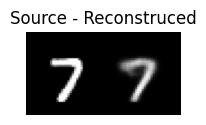

In [29]:
#@title Latent distributions { run: "auto" }

def reconstruct_images(images, model):
    model.eval()
    with torch.no_grad():
        images, _, _ = model(images.to(device))
        images = images.clamp(0, 1)
        return images



digit = 7 #@param {type:"slider", min:0, max:9, step:1}
digits_style = 20 #@param {type:"slider", min:0, max:42, step:1}

image = label2img[digit][digits_style]
bigimage = torch.cat((image,reconstruct_images(image, vae))).cpu()

mus, logvars = vae.encoder(image)
std = (logvars // 2 ).exp().squeeze().cpu()
mus = mus.squeeze().cpu()

plt.figure(figsize = (2, 17))
plt.imshow(torchvision.utils.make_grid(bigimage, 10, 5).permute(1, 2, 0))
plt.title("Source - Reconstruced")
plt.axis('off')
plt.show()


samples = 5000
bivariate_nd = torch.distributions.MultivariateNormal(loc=mus, covariance_matrix=std.diag())
bidist = bivariate_nd.sample((samples,))

fig = go.Figure()
fig.add_trace(go.Histogram2d(x=bidist[:, 0], y=bidist[:, 1],
                             xbins=dict(start=-5, end=5, size=0.1),
                             ybins=dict(start=-5, end=5, size=0.1),
                             histnorm='probability'))
fig.update_traces(opacity=0.6)
fig.update_layout(
    title="Distribution from which we sample for each image",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ),
    height=800,
    width=800,
    autosize=False,
)
fig.show()


samples = 5000
nd1 = torch.distributions.Normal(loc=mus[0], scale=std[0])
nd2 = torch.distributions.Normal(loc=mus[1], scale=std[1])

dist1 = nd1.sample((samples,))
dist2 = nd2.sample((samples,))

fig = go.Figure()
fig.add_trace(go.Histogram(x=dist1,
                           xbins=dict(start=-5, end=5, size=0.005),
                           histnorm='probability', name="0-th latent dim"))
fig.add_trace(go.Histogram(x=dist2,
                           xbins=dict(start=-5, end=5, size=0.005),
                           histnorm='probability',
                           name="1-th latent dim"))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.4)
fig.update_layout(
    title="Probability distributions of each latent dimension",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ),
    height=300
)
fig.show()


### Visualize Reconstructions


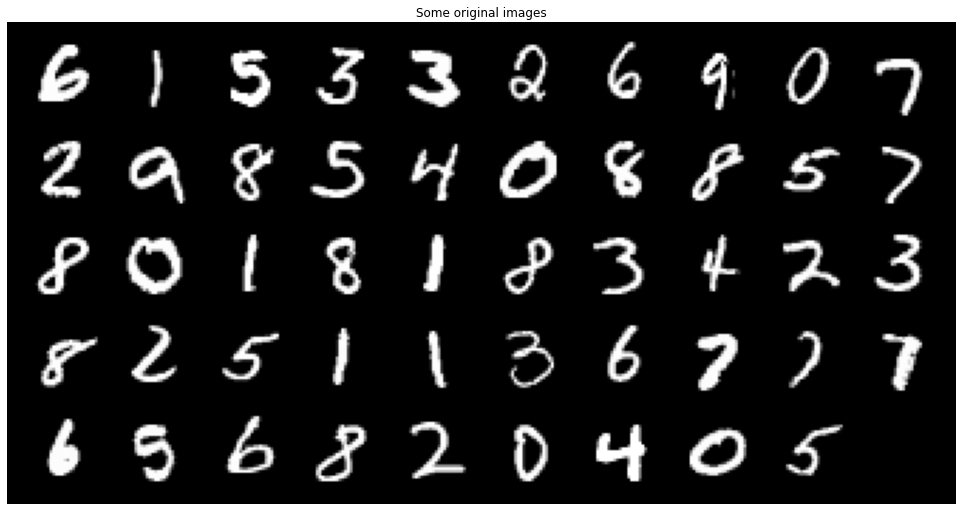

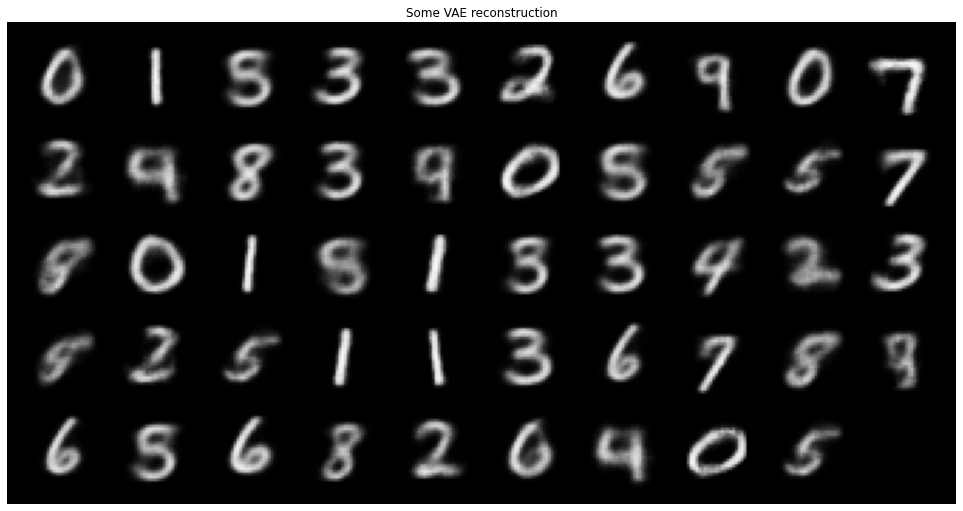

In [ ]:
import torchvision.utils

images, labels = next(iter(test_dataloader))
reconstruced_images = reconstruct_images(images, vae).cpu()

# Matplolib plot, much faster for static images
# First visualise the original images
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(images[1:50],10,5).permute(1, 2, 0))
plt.title("Some original images")
plt.axis('off')
plt.show()

# Reconstruct and visualise the images using the vae
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(reconstruced_images[1:50], 10, 5).permute(1, 2, 0))
plt.title("Some VAE reconstruction")
plt.axis('off')
plt.show()

# # To use plotly:
# # First visualise the original images
# px.imshow(torchvision.utils.make_grid(images[1:50],10,5).permute(1, 2, 0),
#           title="Some original images",
#           color_continuous_scale='grayscale',
#           color_continuous_midpoint=0.5).show()

# # Reconstruct and visualise the images using the vae
# px.imshow(torchvision.utils.make_grid(reconstruced_images[1:50], 10, 5).permute(1, 2, 0),
#           title="Some VAE reconstruction",
#           color_continuous_scale='grayscale',
#           color_continuous_midpoint=0.5).show()

### Interpolate in Latent Space


In [ ]:
def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_2 + (1- lambda1) * latent_1

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.clamp(0, 1).cpu()

        return inter_image

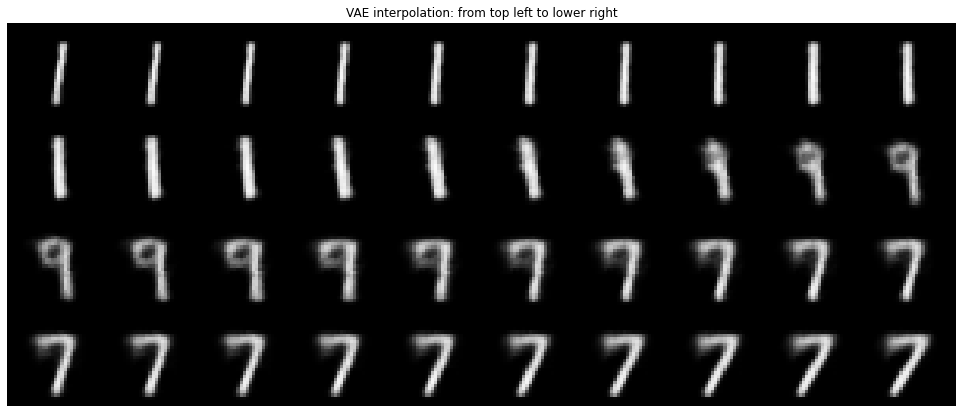

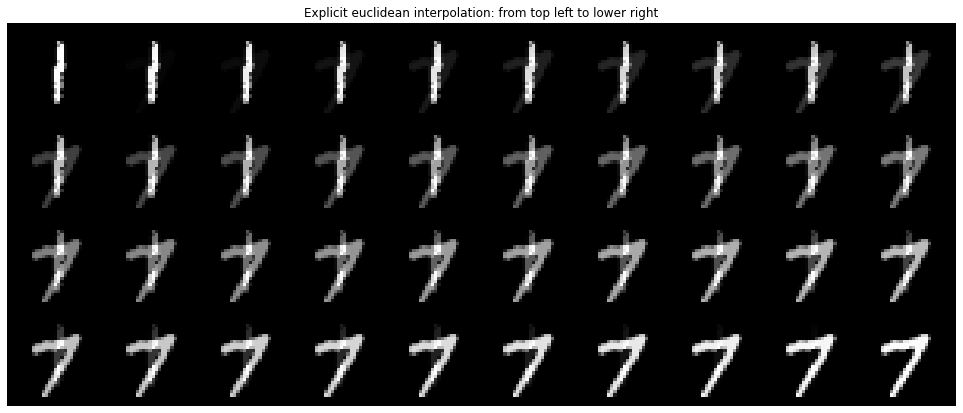

In [ ]:
#@title Playground interpolation { run: "auto" }

def euclidean_interpolation(lambda1, img1, img2):

    with torch.no_grad():

        # explicit interpolation of the images
        inter_image = (1 - lambda1) * img1 + lambda1 * img2

        # reconstruct interpolated image
        inter_image = inter_image.clamp(0, 1).cpu()

        return inter_image

vae.eval()


num_interpolations = 30 #@param {type:"slider", min:10, max:100, step:10}

start_digit = 2 #@param {type:"slider", min:0, max:9, step:1}
end_digit = 7 #@param {type:"slider", min:0, max:9, step:1}
digits_style = 9 #@param {type:"slider", min:0, max:42, step:1}


start_image = label2img[start_digit][digits_style]
end_image = label2img[end_digit][digits_style]

# interpolation lambdas
lambda_range=np.linspace(0,1,num_interpolations)
bigimage = torch.cat([interpolation(x, vae, start_image, end_image) for x in lambda_range])
bigimage_euclidean = torch.cat([euclidean_interpolation(x, start_image, end_image) for x in lambda_range])



# Matplolib plot, much faster for static images
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(bigimage, 10).permute(1, 2, 0))
plt.title("VAE interpolation: from top left to lower right")
plt.axis('off')
plt.show()

# Matplolib plot, much faster for static images
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(bigimage_euclidean, 10).permute(1, 2, 0))
plt.title("Explicit euclidean interpolation: from top left to lower right")
plt.axis('off')
plt.show()


# # To use plotly:
# px.imshow(torchvision.utils.make_grid(bigimage, 10).permute(1, 2, 0),
#           title="VAE interpolation: from top left to lower right",
#           color_continuous_scale='grayscale',
#           color_continuous_midpoint=0.5).show()

### Sample Latent Vector from Prior (VAE as Generator)

By sampling from the latent space, we can use the decoder network to form a generative model capable of creating new data similar to what was observed during training. Specifically, we'll sample from the prior distribution $p(z)$ which we assumed follows a unit Gaussian distribution.

Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder (compare results for the 10d VAE to the results for the autoencoder).

Similar to autoencoders, the manifold of latent vectors that decode to valid digits is sparser in higher-dimensional latent spaces. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction.

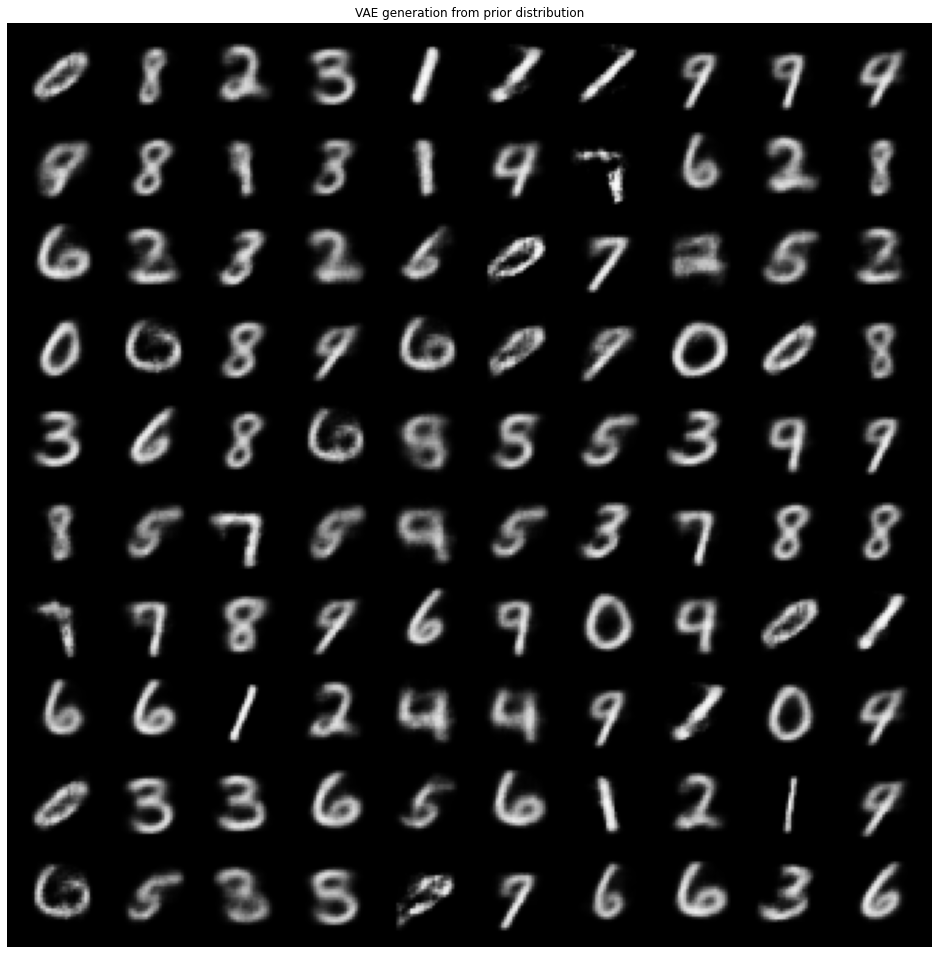

In [ ]:
#@title Playground random generations { run: "auto" }

vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution, our prior distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu().clamp(0, 1)

    # Matplolib plot, much faster for static images
    plt.figure(figsize = (17, 17))
    plt.imshow(torchvision.utils.make_grid(img_recon.data[:100],10,5).permute(1, 2, 0))
    plt.title("VAE generation from prior distribution")
    plt.axis('off')
    plt.show()

    # # To use plotly:
    # px.imshow(torchvision.utils.make_grid(img_recon.data[:100],10,5).permute(1, 2, 0),
    #       title="VAE generation from prior distribution",
    #       color_continuous_scale='grayscale',
    #       color_continuous_midpoint=0.5,
    #       height=1000).show()

#### 2D Latent Space

The figure below visualizes the data generated by the decoder network of a variational autoencoder trained on the MNIST handwritten digits dataset.

Here, we've linearly interpolated a grid of values and displayed the output of our decoder network.

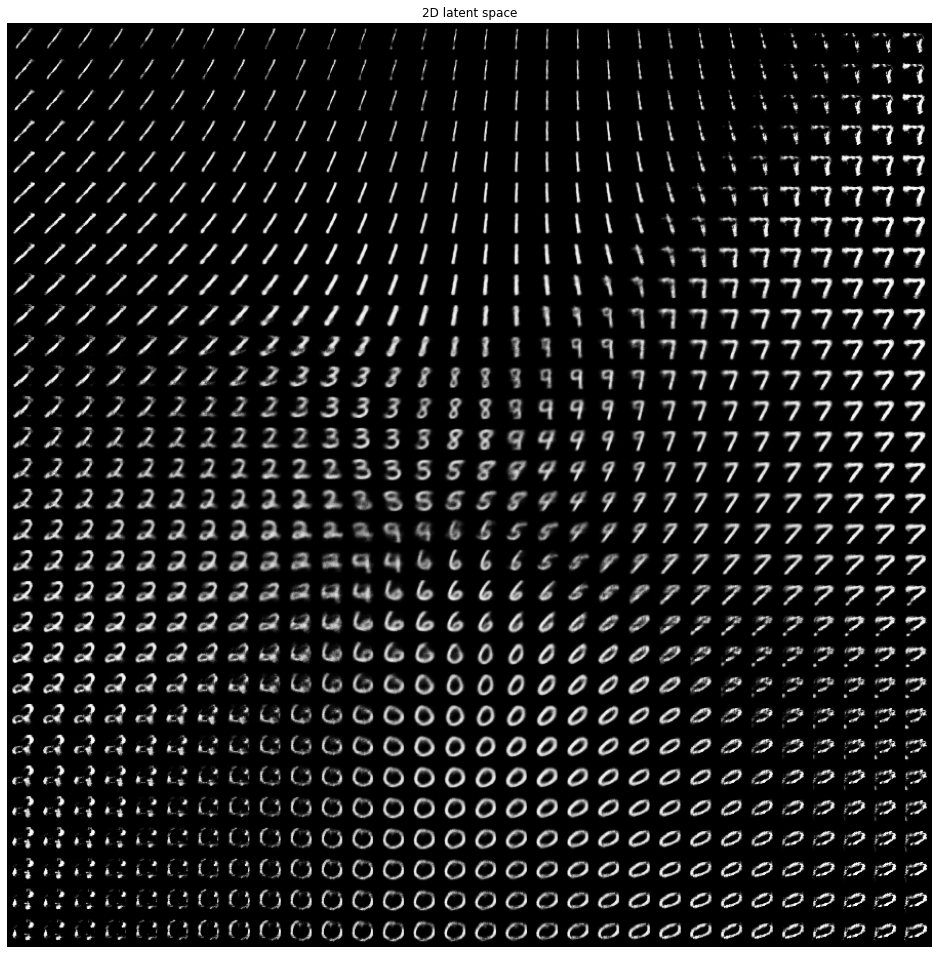

In [ ]:
#@title Playground 2D linear interp { run: "auto" }

import matplotlib.pyplot as plt

latents_lims = 3.66 #@param {type:"slider", min:0.01, max:4, step:0.05}
num_interpolations = 30 #@param {type:"slider", min:10, max:50, step:2}

# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')

with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_interpolation = torch.linspace(-latents_lims, latents_lims, num_interpolations)
    latent_grid = torch.stack(
        (
            latent_interpolation.repeat(num_interpolations, 1),
            latent_interpolation[:, None].repeat(1, num_interpolations)
        ), dim=-1).view(-1, 2)

    # reconstruct images from the latent vectors
    latent_grid = latent_grid.to(device)
    image_recon = vae.decoder(latent_grid)
    image_recon = image_recon.cpu()

    # Matplolib plot, much faster for static images
    plt.figure(figsize = (17, 17))
    plt.imshow(torchvision.utils.make_grid(image_recon.data[:num_interpolations ** 2],
                                          num_interpolations).permute(1, 2, 0))
    plt.title("2D latent space")
    plt.axis('off')
    plt.show()

    # To use plotly:
    # px.imshow(torchvision.utils.make_grid(image_recon.data[:num_interpolations ** 2],
    #                                       num_interpolations),
    #       title="2D latent space",
    #       color_continuous_scale='grayscale',
    #       color_continuous_midpoint=0.5,
    #       height=1000).show()

...why is it distorted?

We are doing a linear interpolation over a (multivariate) gaussian distribution!

To get an undistorted sense of the full latent manifold, we can sample and decode latent space coordinates proportionally to the model’s distribution over latent space. In other words, we sample relative to our chosen prior distribution over z.

In our case, this means sampling linearly spaced percentiles from the [inverse CDF](http://work.thaslwanter.at/Stats/html/statsDistributions.html#other-important-presentations-of-probability-densities) of a spherical Gaussian.

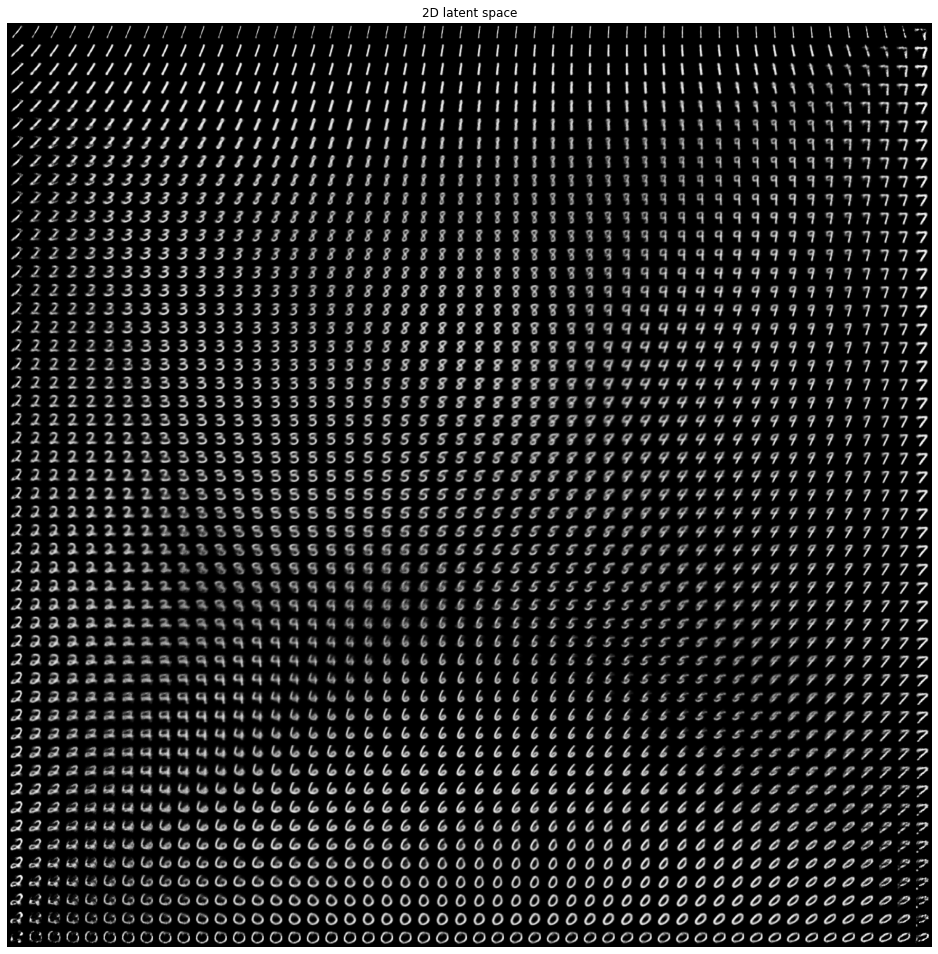

In [ ]:
#@title Playground 2D icdf interp { run: "auto" }

import matplotlib.pyplot as plt

num_interpolations = 50 #@param {type:"slider", min:10, max:50, step:2}

from scipy import stats

nd = torch.distributions.Normal(loc=torch.as_tensor([0.]),
                                scale=torch.as_tensor([1.]))

with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_interpolation = torch.linspace(0.001, 0.999, num_interpolations)
    latent_grid = torch.stack(
        (
            latent_interpolation.repeat(num_interpolations, 1),
            latent_interpolation[:, None].repeat(1, num_interpolations)
        ), dim=-1).view(-1, 2)

    latent_grid = nd.icdf(latent_grid)
    # reconstruct images from the latent vectors
    latent_grid = latent_grid.to(device)
    image_recon = vae.decoder(latent_grid)
    image_recon = image_recon.cpu()

    # Matplolib plot, much faster for static images
    plt.figure(figsize = (17, 17))
    plt.imshow(torchvision.utils.make_grid(image_recon.data[:num_interpolations ** 2],
                                          num_interpolations).permute(1, 2, 0))
    plt.title("2D latent space")
    plt.axis('off')
    plt.show()


---

Section inspired from [this](https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb) tutorial and these blog posts:
[post1](https://blog.fastforwardlabs.com/2016/08/22/under-the-hood-of-the-variational-autoencoder-in.html)
[post2](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)
[post3](https://www.jeremyjordan.me/variational-autoencoders/), [post4](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)

# Credits
We adopted the teaching material from
Deep Learning & Applied AI @Sapienza Univerisity of Rome. Big thanks to

- Luca Moschella (moschella@di.uniroma1.it)
- Marco Fumero (fumero@di.uniroma1.it)
- Irene Cannistraci (cannistraci@di.uniroma1.it)